<a href="https://colab.research.google.com/github/Zhachory1/MusicNST/blob/master/MusicStyleTransferProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Install Dependencies
!pip install py-midi pretty_midi

     |████████████████████████████████| 194kB 46.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/65/4d/a3/f8e50d46e7245398bf625c0b7e640e796b82253539b30a4e74
Successfully built py-midi


In [0]:
#@title Import Libraries
import numpy as np
import time
import argparse
import warnings
import midi
import pretty_midi

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imread, imresize, imsave, fromimage, toimage


from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model  

Using TensorFlow backend.


In [0]:
#@title Load VGG Model 
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
#@title Global Params
result_prefix = ""
style_masks = None
content_mask = None
color_mask = None
content_weight = 0.025
style_weight = [1.0]
style_scale =1.0
total_variation_weight = 8.5e-5
num_iter = 100
model = "vgg16"
content_loss_type = 0
rescale_image = "False"
rescale_method ="bilinear"
content_layer ="conv5_2"
init_image = "content"
pooltype = "max"
preserve_color = "False"
min_improvement = 0.0
pooltype = 1 if pooltype == "ave" else 0
# dimensions of the generated picture.
input_width = input_height = 0
input_WIDTH = input_HEIGHT = 0
aspect_ratio = 2

music_size = 128

In [0]:
#@title preprocess_preprocess_music_for_vgg_for_vgg 
#@markdown Util function to open, resize and format music into appropriate tensors
def preprocess_music_for_vgg(music, load_dims=False):
    global input_width, input_height, input_WIDTH, input_HEIGHT, aspect_ratio

    # Expand the temporal music into a 3 channled tensor to complement VGG input
    temp = np.zeros(music.shape + (3,), dtype=np.uint8)
    temp[:, :, 0] = music
    temp[:, :, 1] = music.copy()
    temp[:, :, 2] = music.copy()

    music = temp

    if load_dims:
        input_WIDTH = music.shape[0]
        input_HEIGHT = music.shape[1]
        aspect_ratio = float(input_HEIGHT) / input_WIDTH

        input_width = music_size
        input_height = int(input_width * aspect_ratio)

    music = imresize(music, (input_width, input_height)).astype('float32')


    music = np.expand_dims(music, axis=0)
    return music

In [0]:
# util function to preserve image color
def original_color_transform(content, generated, mask=None):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space

    if mask is None:
        generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    else:
        width, height, channels = generated.shape

        for i in range(width):
            for j in range(height):
                if mask[i, j] == 1:
                    generated[i, j, 1:] = content[i, j, 1:]

    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated

In [0]:
def pooling_func(x):
    if pooltype == 1:
        return AveragePooling2D((2, 2), strides=(2, 2))(x)
    else:
        return MaxPooling2D((2, 2), strides=(2, 2))(x)

In [0]:
def get_inputs(content_img, style_img):
# Content Model
  # get tensor representations of our images
  base_image = K.variable(preprocess_music_for_vgg(content_img, True))

  style_reference_images = []
  style_reference_images.append(K.variable(preprocess_music_for_vgg(style_img)))

  combination_image = K.placeholder((1, input_width, input_height, 3))

  image_tensors = [base_image]
  for style_image_tensor in style_reference_images:
      image_tensors.append(style_image_tensor)
  image_tensors.append(combination_image)

  nb_tensors = len(image_tensors)
  nb_style_images = nb_tensors - 2 # Content and Output image not considered

  # combine the various images into a single Keras tensor
  input_tensor = K.concatenate(image_tensors, axis=0)

  print("nb_tensors")
  print(nb_tensors)
  print("input_width")
  print(input_width)
  print("input_height")
  print(input_height)  
  if K.image_dim_ordering() == "th":
      shape = (nb_tensors, 3, input_width, input_height)
  else:
      shape = (nb_tensors, input_width, input_height, 3)
      
  return input_tensor, shape, combination_image, nb_tensors   

In [0]:
def get_model(input_tensor, shape):  
  ip = Input(tensor=input_tensor, batch_shape=shape)

  # build the VGG16 network with our 3 images as input
  x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding='same')(ip)
  x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
  x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
  x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
  x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
  if model == "vgg19":
      x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
  if model == "vgg19":
      x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
  if model == "vgg19":
      x = Convolution2D(512, (3, 3), activation='relu', name='conv5_4', padding='same')(x)
  x = pooling_func(x)

  return Model(ip, x)

In [0]:
def get_custom_model(shape):
  ip = Input(batch_shape=shape)
  layer_2 = ip
  if use_batchnorm:
    layer_2 = BatchNormalization(axis=-1)(layer_2)
  layer_2 = Convolution1D(filters=64, kernel_size=32, activation='elu', padding='same')(layer_2)
  if use_dropout:
    layer_2 = Dropout(rate=0.1)(layer_2)
  layer_2 = Convolution1D(filters=16, kernel_size=8, activation='elu', padding='same')(layer_2)
  layer_2 = Convolution1D(filters=1, kernel_size=4, activation='elu', padding='same')(layer_2)
  layer_2 = Lambda(lambda x: backend.squeeze(x, axis=-1))(layer_2)
  dense_1 = Dense(units=50, activation='elu')(layer_2)
  if use_dropout:
    layer_2 = Dropout(rate=0.1)(layer_2)
  dense_1 = Dense(units=32, activation='elu')(dense_1)
  dense_1 = Dense(units=NUM_UNIQUE_COMPOSERS, activation='elu')(dense_1)
  dense_1 = Dense(units=NUM_UNIQUE_COMPOSERS, activation='softmax')(dense_1)
  return Model(ip, dense_1)

In [0]:
def load_model(vgg_model):
  if model == "vgg19":
      weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  else:
      weights = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_WEIGHTS_PATH_NO_TOP, cache_subdir='models')

  vgg_model.load_weights(weights)

  if K.backend() == 'tensorflow' and K.image_dim_ordering() == "th":
      warnings.warn('You are using the TensorFlow backend, yet you '
                    'are using the Theano '
                    'image dimension ordering convention '
                    '(`image_dim_ordering="th"`). '
                    'For best performance, set '
                    '`image_dim_ordering="tf"` in '
                    'your Keras config '
                    'at ~/.keras/keras.json.')
      convert_all_kernels_in_model(vgg_model)
  print('Model loaded.')

In [0]:
def get_output_dict_and_shape(vgg_model):
  # get the symbolic outputs of each "key" layer (we gave them unique names).
  outputs_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])
  shape_dict = dict([(layer.name, layer.output_shape) for layer in vgg_model.layers])
  return outputs_dict, shape_dict

In [0]:
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
#     assert K.ndim(x) == 3
    if K.image_dim_ordering() == "th":
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination, mask_path=None, nb_channels=None):
#     assert K.ndim(style) == 3
#     assert K.ndim(combination) == 3

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = input_width * input_height
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    channel_dim = 0 if K.image_dim_ordering() == "th" else -1

    try:
        channels = K.int_shape(base)[channel_dim]
    except TypeError:
        channels = K.shape(base)[channel_dim]
    size = input_width * input_height

    if content_loss_type == 1:
        multiplier = 1. / (2. * (channels ** 0.5) * (size ** 0.5))
    elif content_loss_type == 2:
        multiplier = 1. / (channels * size)
    else:
        multiplier = 1.

    return multiplier * K.sum(K.square(combination - base))

In [0]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :input_width - 1, :input_height - 1, :] - x[:, 1:, :input_height - 1, :])
    b = K.square(x[:, :input_width - 1, :input_height - 1, :] - x[:, :input_width - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
def get_loss(outputs_dict, shape_dict, combination_image, nb_tensors):  
  # combine these loss functions into a single scalar
  loss = K.variable(0.)
  layer_features = outputs_dict[content_layer]  # 'conv5_2' or 'conv4_2'
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[nb_tensors - 1, :, :, :]
  loss = loss + content_weight * content_loss(base_image_features,
                                        combination_features)
  style_masks = [None] # If masks not present, pass None to the style loss

  channel_index = 1 if K.image_dim_ordering() == "th" else -1
  feature_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
  for layer_name in feature_layers:
      layer_features = outputs_dict[layer_name]
      shape = shape_dict[layer_name]
      combination_features = layer_features[nb_tensors - 1, :, :, :]

      style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
      sl = []
      sl.append(style_loss(style_reference_features[0], combination_features, style_masks[0], shape))
      loss = loss + (1 / len(feature_layers)) * sl[0]

  loss = loss + total_variation_weight * total_variation_loss(combination_image)
  return loss
  
def get_grad(loss, combination_image):
  # get the gradients of the generated image wrt the loss
  grads = K.gradients(loss, combination_image)
  outputs = [loss]
  if type(grads) in {list, tuple}:
      outputs += grads
  else:
      outputs.append(grads)
  return outputs

In [0]:
def eval_loss_and_grads(x, f_outputs):
    x = x.reshape((1, input_width, input_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self, f_outputs):
        self.loss_value = None
        self.grads_values = None
        self.f_outputs = f_outputs

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x, self.f_outputs)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# MIDI time
---



In [0]:
style_music = "MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi"

from google.colab import files
uploaded = files.upload()

In [0]:
content_music = "MIDI-Unprocessed_083_PIANO083_MID--AUDIO-split_07-09-17_Piano-e_2_-06_wav--5.midi"
from google.colab import files
uploaded = files.upload()

In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
def get_music(path):
  midi_pretty_format = pretty_midi.PrettyMIDI(path)
  piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
  piano_roll = piano_midi.get_piano_roll(fs=5)
  piano_roll=piano_roll[:,:256]
  return piano_roll

In [0]:
def piano_roll_to_pretty_midi(piano_roll, fs=5, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [0]:
def deprocess_music(x):
    x = x.reshape((input_width, input_height, 3))

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 100).astype('uint8')
    x = np.where(x < 5, 0, x)
    
    x = x[:, :, 0]
    return x

In [0]:
# Create embedding layer to squeeze to dimensions to 16
c_music = get_music(content_music)
s_music = get_music(style_music)
print(c_music.shape)
print(s_music.shape)
print(c_music[:, :30].max(axis=0))
print(c_music[:, 5])

(128, 256)
(128, 256)
[ 0.  0.  0.  0.  0. 37.  0.  0.  0. 40. 40. 40. 40. 40.  0. 43. 43. 43.
 43. 38.  0.  0.  0.  0.  0.  0. 33.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 37.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


#Run Model 

In [46]:
input_tensor, shape, combination_image, nb_tensors = get_inputs(get_music(content_music), get_music(style_music))
vgg_model = get_model(input_tensor, shape)
load_model(vgg_model)
outputs_dict, shape_dict = get_output_dict_and_shape(vgg_model)
loss = get_loss(outputs_dict, shape_dict, combination_image, nb_tensors)
outputs = get_grad(loss, combination_image)
f_outputs = K.function([combination_image], outputs)
evaluator = Evaluator(f_outputs)

prev_min_val = -1

x = preprocess_music_for_vgg(get_music(content_music))
improvement_threshold = float(min_improvement)

result_prefix = "midi_straight"

loss_aray1= []

for i in range(num_iter):
    print("Starting iteration %d of %d" % ((i + 1), num_iter))
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    
    loss_aray1.append(min_val)
    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100
    

    print('Current loss value:', min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    # save current generated image
    img = deprocess_music(x.copy())

    if not rescale_image:
        img_ht = int(input_width * aspect_ratio)
        print("Rescaling Image to (%d, %d)" % (input_width, img_ht))
        img = imresize(img, (input_width, img_ht), interp=rescale_method)

    if rescale_image:
        print("Rescaling Image to (%d, %d)" % (input_WIDTH, input_HEIGHT))
        img = imresize(img, (input_WIDTH, input_HEIGHT), interp=rescale_method)

    fname = result_prefix + '_at_iteration_%d.midi' % (i + 1)
    img = piano_roll_to_pretty_midi(img)
    img.write(fname)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i + 1, end_time - start_time))

    if improvement_threshold is not 0.0:
        if improvement < improvement_threshold and improvement is not 0.0:
            print("Improvement (%f) is less than improvement threshold (%f). Early stopping script." % (
                improvement, improvement_threshold))
            exit()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


nb_tensors
3
input_width
128
input_height
256
Model loaded.
Starting iteration 1 of 100
('Current loss value:', 2765.7754, ' Improvement : 0.000', '%')
Rescaling Image to (128, 256)
('Image saved as', 'midi_straight_at_iteration_1.midi')
Iteration 1 completed in 2s
Starting iteration 2 of 100


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


('Current loss value:', 2145.4756, ' Improvement : 22.428', '%')
Rescaling Image to (128, 256)
('Image saved as', 'midi_straight_at_iteration_2.midi')
Iteration 2 completed in 0s
Starting iteration 3 of 100
('Current loss value:', 1873.0149, ' Improvement : 12.699', '%')
Rescaling Image to (128, 256)
('Image saved as', 'midi_straight_at_iteration_3.midi')
Iteration 3 completed in 0s
Starting iteration 4 of 100
('Current loss value:', 1683.6101, ' Improvement : 10.112', '%')
Rescaling Image to (128, 256)
('Image saved as', 'midi_straight_at_iteration_4.midi')
Iteration 4 completed in 0s
Starting iteration 5 of 100
('Current loss value:', 1518.9745, ' Improvement : 9.779', '%')
Rescaling Image to (128, 256)
('Image saved as', 'midi_straight_at_iteration_5.midi')
Iteration 5 completed in 0s
Starting iteration 6 of 100
('Current loss value:', 1383.9907, ' Improvement : 8.887', '%')
Rescaling Image to (128, 256)
('Image saved as', 'midi_straight_at_iteration_6.midi')
Iteration 6 completed i

In [0]:
files.download("midi_straight_at_iteration_100.midi")

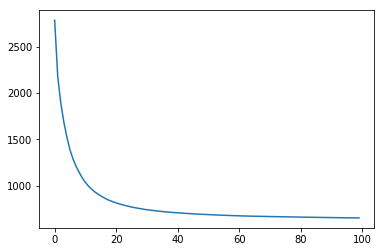

In [0]:
import matplotlib.pyplot as plt

plt.plot(loss_aray, loss_aray1)